# *Monod* demonstration: analysis of normalization procedures

We have run the *Monod* inference pipeline on seven pre-clustered mouse brain cell glutamatergic subtypes, as well as the entire glutamatergic cell type. In this notebook, we analyze whether the amount of biological variation between the subtypes concords with the amount of biological variation predicted by normalization and mechanistic fit procedures.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()


In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [3]:
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt

Import search results.

In [4]:
dataset_meta = ['B08','C01','F08','H12']

subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic','GABAergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta[:1] for y in cluster_names[:1]]  
raw_data_locations = [dataset_meta[0] for y in subcluster_names] + [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

n_datasets = len(dataset_names)


In [5]:
dir_string = './fits/gg_220913_024_allen_celltypes_2'
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]

In [6]:
dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b',
 'allen_B08_Glutamatergic']

In [7]:
sr_arr = []
sd_arr = []


for j in range(n_datasets):
    sd = monod.analysis.load_search_data(sd_strings[j])
    sr = monod.analysis.load_search_results(result_strings[j])
    
    sd_arr.append(sd)
    sr_arr.append(sr)


In [8]:
#a e s t h e t i c s
fs = 16

In [9]:
from scipy import stats

Compute the normalization-based estimate.

In [10]:
f_bio_naive = sd_arr[-1].get_noise_decomp()[:,0,1] #biological noise over whole dataset, by normalization

Compute lower limit on biological variation, taking into account the cluster differences.

In [11]:
var_total = sd_arr[-1].layers[1].var(1)
mean_total = sd_arr[-1].layers[1].mean(1)

subtype_means = np.asarray([x.layers[1].mean(1) for x in sd_arr[:-1]])
n_cells = np.asarray([x.n_cells for x in sd_arr[:-1]])
n_cells = n_cells/(n_cells.sum())

var_of_means = (((subtype_means-mean_total)**2) * n_cells[:,None]).sum(0)

f_modelfree = var_of_means/var_total

In [12]:
(subtype_means * n_cells[:,None]).sum(0)[:10]

array([ 7.78308067,  1.32135504,  5.17424668,  8.68669287, 10.28092832,
        2.16676025,  8.38068501,  4.96874415,  1.09751076,  3.77653004])

In [13]:
mean_total[:10]

array([ 7.78308067,  1.32135504,  5.17424668,  8.68669287, 10.28092832,
        2.16676025,  8.38068501,  4.96874415,  1.09751076,  3.77653004])

Now, aggregate model-based results to come up with an estimate of the biological variation.

From QC, we know that the subtype sampling parameter fits are roughly concordant with the cell type ones (up to half an order of magnitude difference); however, subtypes with very few cells show the highest deviations. This speaks to challenges in uniquely fitting the data (see scatterplots of gene fits for an example). To account for this, we set the sampling parameters to the values discovered for the whole glutamatergic dataset; otherwise, the analysis is rather more mathematically complicated.

In [14]:
model_moments = []
li = sr_arr[-1].samp_optimum_ind
for j in range(n_datasets-1):

    p = 10**sr_arr[j].param_estimates[li]
    l = 10**sr_arr[j].regressor[li]
    
    p=p.T
    l=l.T
    mu_bio =  p[0]/p[2]
    mu_tech = mu_bio * l[1]
    var_bio = mu_bio*(1+p[0]*p[1]/(p[1]+p[2]))
    var_tech = mu_tech*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
    
    model_moments.append((mu_bio,mu_tech,var_bio,var_tech))
    
model_moments = np.asarray(model_moments)


Aggregate the derived statistics (mean and variance using the MLEs for plug-in parameter estimates) and compute the noise fractions before and after sampling. Divide biological $\text{CV}^2$ by technical to find the fraction of biological variance.

In [15]:
model_moments.shape

(6, 4, 3000)

In [16]:
mean_bio = (model_moments[:,0,:]*n_cells[:,None]).sum(0)
var_bio = (model_moments[:,2,:]*n_cells[:,None]).sum(0) \
        + (((model_moments[:,0,:]-mean_bio)**2)*n_cells[:,None]).sum(0)

mean_tech = (model_moments[:,1,:]*n_cells[:,None]).sum(0)
var_tech = (model_moments[:,3,:]*n_cells[:,None]).sum(0) \
        + (((model_moments[:,1,:]-mean_tech)**2)*n_cells[:,None]).sum(0)

cv2_bio = var_bio/mean_bio**2
cv2_tech = var_tech/mean_tech**2
f_cluster_model = cv2_bio/cv2_tech

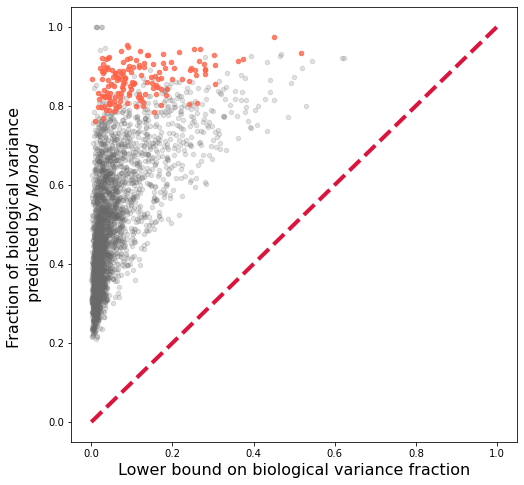

In [17]:
q = np.quantile(mean_total,0.95)
gf = mean_total<q

plt.figure(figsize=(8,8))
plt.scatter(f_modelfree[gf],f_cluster_model[gf],20,'dimgrey',alpha=0.2)
plt.scatter(f_modelfree[~gf],f_cluster_model[~gf],20,'tomato',alpha=0.8)
xl = [0,1]

plt.xlabel('Lower bound on biological variance fraction',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by $\it{Monod}$',fontsize=fs)
plt.plot(xl,xl,'--',c='crimson',linewidth=4)

fig_string = sr.batch_analysis_string+'/mech_var_limit_clusters.png'
plt.savefig(fig_string,dpi=450)

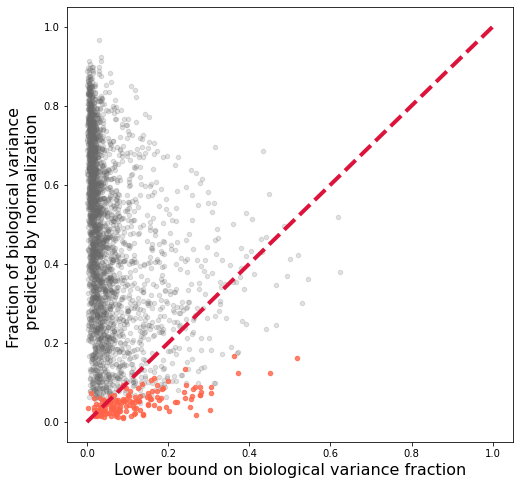

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(f_modelfree[gf],f_bio_naive[gf],20,'dimgrey',alpha=0.2)
plt.scatter(f_modelfree[~gf],f_bio_naive[~gf],20,'tomato',alpha=0.8)
xl = [0,1]
plt.xlabel('Lower bound on biological variance fraction',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by normalization',fontsize=fs)
plt.plot(xl,xl,'--',c='crimson',linewidth=4)

fig_string = sr.batch_analysis_string+'/norm_var_limit_clusters.png'
plt.savefig(fig_string,dpi=450)

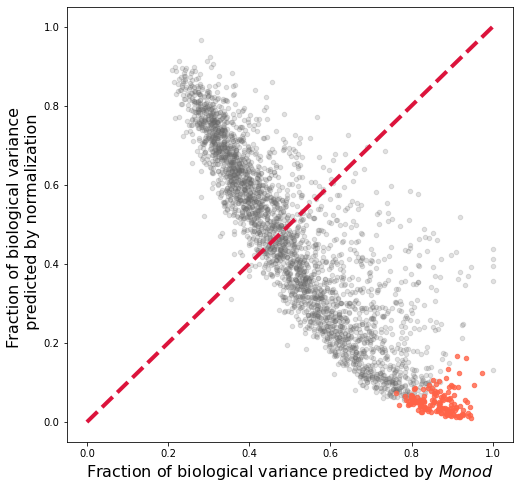

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(f_cluster_model[gf],f_bio_naive[gf],20,'dimgrey',alpha=0.2)
plt.scatter(f_cluster_model[~gf],f_bio_naive[~gf],20,'tomato',alpha=0.8)
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
plt.xlabel('Fraction of biological variance predicted by $\it{Monod}$',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by normalization',fontsize=fs)

fig_string = sr.batch_analysis_string+'/mech_norm_var_clusters.png'
plt.savefig(fig_string,dpi=450)

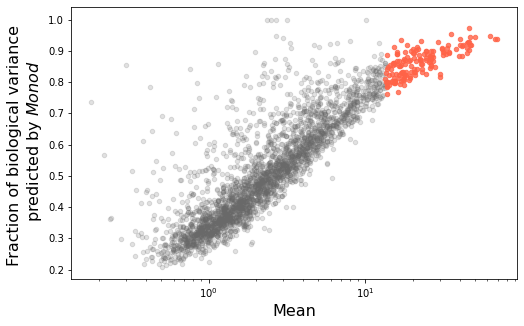

In [20]:
plt.figure(figsize=(8,5))
plt.scatter(mean_total[gf],f_cluster_model[gf],20,'dimgrey',alpha=0.2)
plt.scatter(mean_total[~gf],f_cluster_model[~gf],20,'tomato',alpha=0.8)
plt.xlabel('Mean',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by $\it{Monod}$',fontsize=fs)

plt.xscale('log')

fig_string = sr.batch_analysis_string+'/mech_var_mean_allclusters.png'
plt.savefig(fig_string,dpi=450)

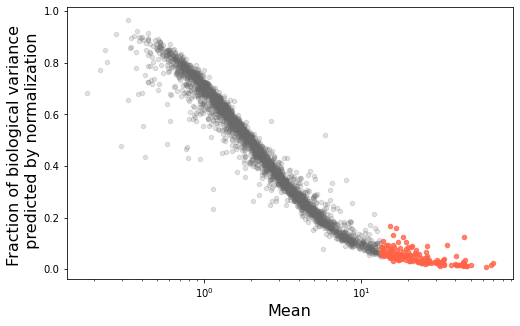

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(mean_total[gf],f_bio_naive[gf],20,'dimgrey',alpha=0.2)
plt.scatter(mean_total[~gf],f_bio_naive[~gf],20,'tomato',alpha=0.8)
plt.xlabel('Mean',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by normalization',fontsize=fs)

plt.xscale('log')

fig_string = sr.batch_analysis_string+'/norm_var_mean_allclusters.png'
plt.savefig(fig_string,dpi=450)

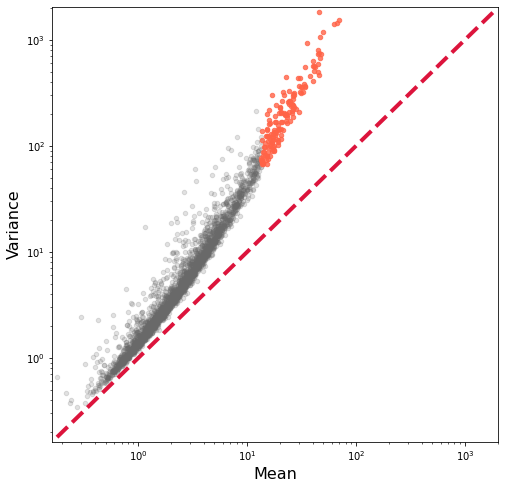

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(mean_total[gf],var_total[gf],20,'dimgrey',alpha=0.2)
plt.scatter(mean_total[~gf],var_total[~gf],20,'tomato',alpha=0.8)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'Variance',fontsize=fs)
plt.xlabel(r'Mean',fontsize=fs)
xl = [mean_total.min(),var_total.max()]
plt.xlim([mean_total.min()*0.9,var_total.max()*1.1])
plt.ylim([mean_total.min()*0.9,var_total.max()*1.1])
plt.plot(xl,xl,'--',c='crimson',linewidth=4)

fig_string = sr.batch_analysis_string+'/meanvar.png'
plt.savefig(fig_string,dpi=450)

We can rerun the analysis using mechanistic noise model applied to the whole dataset. It turns out to be highly consistent.


In [23]:
d = sr_arr[-1].get_noise_decomp()
f_cluster_model = d[:,1,1]+d[:,0,1] # bio noise over the whole dataset

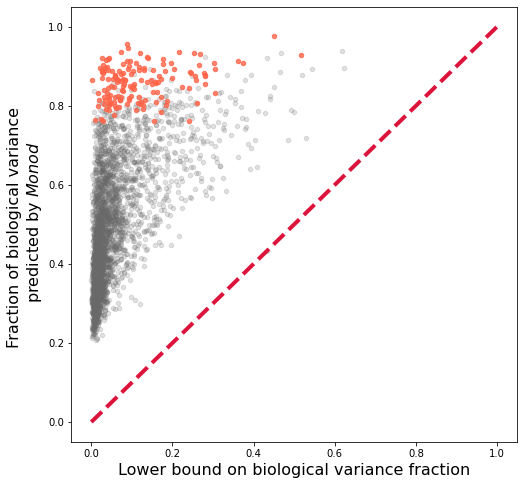

In [24]:
q = np.quantile(mean_total,0.95)
gf = mean_total<q

plt.figure(figsize=(8,8))
plt.scatter(f_modelfree[gf],f_cluster_model[gf],20,'dimgrey',alpha=0.2)
plt.scatter(f_modelfree[~gf],f_cluster_model[~gf],20,'tomato',alpha=0.8)
xl = [0,1]
plt.xlabel('Lower bound on biological variance fraction',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by $\it{Monod}$',fontsize=fs)
plt.plot(xl,xl,'--',c='crimson',linewidth=4)

fig_string = sr.batch_analysis_string+'/mech_var_limit_aggregated.png'
plt.savefig(fig_string,dpi=450)

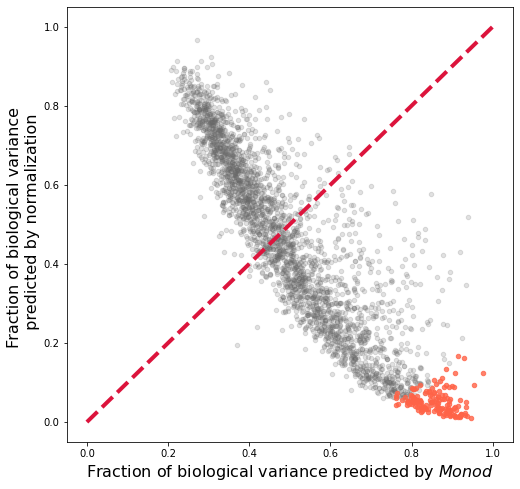

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(f_cluster_model[gf],f_bio_naive[gf],20,'dimgrey',alpha=0.2)
plt.scatter(f_cluster_model[~gf],f_bio_naive[~gf],20,'tomato',alpha=0.8)
plt.plot([0,1],[0,1],'--',c='crimson',linewidth=4)
plt.xlabel('Fraction of biological variance predicted by $\it{Monod}$',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by normalization',fontsize=fs)

fig_string = sr.batch_analysis_string+'/mech_norm_var_aggregated.png'
plt.savefig(fig_string,dpi=450)

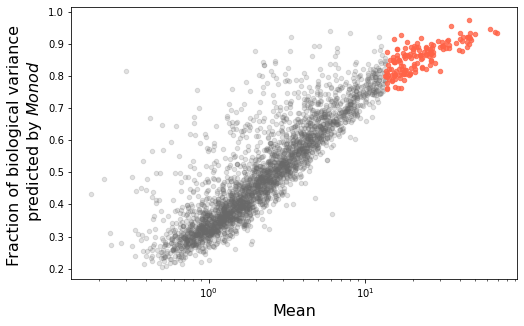

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(mean_total[gf],f_cluster_model[gf],20,'dimgrey',alpha=0.2)
plt.scatter(mean_total[~gf],f_cluster_model[~gf],20,'tomato',alpha=0.8)
plt.xlabel('Mean',fontsize=fs)
plt.ylabel('Fraction of biological variance \n predicted by $\it{Monod}$',fontsize=fs)

plt.xscale('log')

fig_string = sr.batch_analysis_string+'/mech_var_mean_aggregated.png'
plt.savefig(fig_string,dpi=450)

In [27]:
t2 = time.time()
print('Runtime: {:.2f} seconds.'.format(t2-t1))

Runtime: 13.80 seconds.
